# Install Torch and Pycocotools

In [1]:
!pip install torch torchvision -q
!pip install pycocotools lxml tqdm -q

# Unzip the coco dataset

In [4]:
!unzip coco.zip

Archive:  coco.zip
   creating: coco/
  inflating: coco/README.txt         
   creating: coco/test/
  inflating: coco/test/100001.jpg    
  inflating: coco/test/100007.jpg    
  inflating: coco/test/100011.jpg    
  inflating: coco/test/100014.jpg    
  inflating: coco/test/100017.jpg    
  inflating: coco/test/100021.jpg    
  inflating: coco/test/100025.jpg    
  inflating: coco/test/100036.jpg    
  inflating: coco/test/100040.jpg    
  inflating: coco/test/100042.jpg    
  inflating: coco/test/100060.jpg    
  inflating: coco/test/100070.jpg    
  inflating: coco/test/100071.jpg    
  inflating: coco/test/100073.jpg    
  inflating: coco/test/100076.jpg    
  inflating: coco/test/100085.jpg    
  inflating: coco/test/100093.jpg    
  inflating: coco/test/100109.jpg    
  inflating: coco/test/100131.jpg    
  inflating: coco/test/100132.jpg    
  inflating: coco/test/100134.jpg    
  inflating: coco/test/100150.jpg    
  inflating: coco/test/100157.jpg    
  inflating: coco/test/100

 # Import Necessary Modules

In [2]:

import os
import xml.etree.ElementTree as ET
import torch
from torchvision.transforms import functional as F
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Define Classes

In [3]:
CLASSES = ['__background__', 'Ready', 'empty_pod', 'germination', 'pod', 'young']
NUM_CLASSES = len(CLASSES)

# Define the CocoDataset Class
Here, we also implement a functionality to handle the images with no annotations, these images are then
as background

In [4]:
from pycocotools.coco import COCO
class CocoDataset(Dataset):
    def __init__(self, img_folder, ann_file, transforms=None):
        self.root = img_folder
        self.coco = COCO(ann_file)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transforms = transforms

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        img_info = coco.loadImgs(img_id)[0]
        path = img_info['file_name']
        img_path = os.path.join(self.root, path)
        img = Image.open(img_path).convert('RGB')

        boxes = []
        labels = []

        if len(anns) == 0:
       
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            for ann in anns:
                x, y, w, h = ann['bbox']
                boxes.append([x, y, x + w, y + h])
                labels.append(ann['category_id'])

            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([img_id])

        target = {
        "boxes": boxes,
        "labels": labels,
        "image_id": image_id,
        }

        if self.transforms:
            img, target = self.transforms(img, target)
        else:
            img = F.to_tensor(img)

        return img, target


    def __len__(self):
        return len(self.ids)

# Define our Train,Val and Test Datsets and their Loaders

In [5]:
train_dataset = CocoDataset(img_folder='coco/train', ann_file='coco/train/train_annotations.json')
val_dataset = CocoDataset(img_folder='coco/valid', ann_file='coco/valid/valid_annotations.json')
test_dataset = CocoDataset(img_folder='coco/test', ann_file = 'coco/test/test_annotations.json')


train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


# Define the Get Model function
Here, we import the mobilenet model as a base for our faster RCNN model and modify to make it trainable, we get the number of input features for the classifier head, and then we replace the pretrained head with a new head for specific number of classes

In [6]:
def get_model(num_classes):
   
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [7]:


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


model = get_model(NUM_CLASSES).to(device)

# Good point to print and check our model

In [8]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

# Implement checkpointing to save the model every iteration
This also saves the optimizer and the current epoch 

In [9]:
import torch

def save_model(model, optimizer, epoch, filename="checkpoint.pth"):
    """
    Saves the model and optimizer state for later training or inference.
    Args:
        model (torch.nn.Module): The model to save.
        optimizer (torch.optim.Optimizer): The optimizer used during training.
        epoch (int): Current training epoch.
        filename (str): File name to save the checkpoint.
    """
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, filename)
    print(f"✅ Saved model checkpoint to: {filename}")

# Define the evaluate_map function
This code is inspired from the lab code, however modified to take dataloader as a parameter instead of a dataset.

In [10]:
def evaluate_map(model, dataloader, iou_thresholds=[0.5, 0.75]):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

           
            outputs = model(images)

           
            for pred, target in zip(outputs, targets):
                keep = pred['scores'] > 0.05
                pred_boxes = pred['boxes'][keep].cpu()
                pred_labels = pred['labels'][keep].cpu()
                pred_scores = pred['scores'][keep].cpu()

                all_preds.append({
                    'boxes': pred_boxes,
                    'labels': pred_labels,
                    'scores': pred_scores
                })

                all_targets.append({
                    'boxes': target['boxes'].cpu(),
                    'labels': target['labels'].cpu()
                })

    return compute_map_ar(all_preds, all_targets)



# Define Metric computation
This will be used to evaluate as well as validate when the model is getting trained.

In [11]:
def compute_map_ar(preds, targets, num_classes=len(CLASSES)-1):
    # Initialize the results dictionary with default values
    results = {
        'map': 0, 'map_50': 0, 'map_75': 0,
        'map_per_class': torch.zeros(num_classes),
        'mar_1': 0, 'mar_10': 0, 'mar_100': 0,
        'mar_100_per_class': torch.zeros(num_classes),
    }

    # Lists to hold AP and AR values for each class
    aps = [[] for _ in range(num_classes)]
    ars = [[] for _ in range(num_classes)]

    # Loop through each image's predictions and targets
    for pred, target in zip(preds, targets):
        # Loop through each class (excluding background)
        for class_idx in range(1, num_classes+1):
            # Filter boxes by current class
            gt_mask = target['labels'] == class_idx
            pred_mask = pred['labels'] == class_idx

            gt_boxes = target['boxes'][gt_mask]
            pred_boxes = pred['boxes'][pred_mask]
            pred_scores = pred['scores'][pred_mask]

            # Skip if no GT or predictions
            if len(gt_boxes) == 0 and len(pred_boxes) == 0:
                continue

            # Compute IoUs between predictions and ground truth
            ious = box_iou(pred_boxes, gt_boxes) if len(gt_boxes) > 0 and len(pred_boxes) > 0 else torch.zeros((0, 0))

            # Initialize true positives (TP) and matched GT indices
            tp = torch.zeros(len(pred_boxes))
            matched = set()

            # Match predictions to ground truth based on IoU > 0.5
            for i, row in enumerate(ious):
                max_iou, max_j = torch.max(row, dim=0)
                if max_iou > 0.5 and max_j.item() not in matched:
                    tp[i] = 1
                    matched.add(max_j.item())

            # Compute false positives (FP)
            fp = 1 - tp

            # Cumulative TP and FP for precision-recall curve
            cum_tp = torch.cumsum(tp, dim=0)
            cum_fp = torch.cumsum(fp, dim=0)

            # Compute recall and precision
            recalls = cum_tp / (len(gt_boxes) + 1e-6)
            precisions = cum_tp / (cum_tp + cum_fp + 1e-6)

            # Compute AP (area under precision-recall curve)
            ap = torch.trapz(precisions, recalls) if recalls.numel() > 0 else torch.tensor(0.)
            # AR is the max recall value
            ar = recalls[-1] if recalls.numel() > 0 else torch.tensor(0.)

            # Store per-class AP and AR
            aps[class_idx-1].append(ap.item())
            ars[class_idx-1].append(ar.item())

    # Compute average AP and AR for each class
    ap_avg = torch.tensor([np.mean(cls_ap) if cls_ap else 0. for cls_ap in aps])
    ar_avg = torch.tensor([np.mean(cls_ar) if cls_ar else 0. for cls_ar in ars])

    # Save results
    results['map_per_class'] = ap_avg
    results['mar_100_per_class'] = ar_avg
    results['map'] = ap_avg.mean()
    results['map_50'] = ap_avg.mean()
    results['map_75'] = ap_avg.mean()
    results['mar_100'] = ar_avg.mean()
    results['mar_10'] = ar_avg.mean()
    results['mar_1'] = ar_avg.mean()

    return results


# Define Setup : epochs, optimizer, and logging
We have set our epochs to 250, this code is inspired from the lab code.

In [12]:

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)


num_epochs = 250 

start_epoch = 0


print_every = 1        
save_every = 1         
val_every = 1         
save_dir = 'training1'
os.makedirs(save_dir, exist_ok=True)


epoch_losses = []
iteration_losses = []
val_maps = []



# The Training loop, with earlystopping
Here we implement our training loop, and also implement earlystopping with a patience of 40, also, we save the best model based of the mAP for the validation dataset

In [13]:

best_val_map = 0.0
patience = 40
epochs_without_improvement = 0

for epoch in range(start_epoch, num_epochs):
    model.train()
    total_loss = 0

    for i, (images, targets) in enumerate(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        iteration_losses.append(losses.item())

       # if (i + 1) % print_every == 0:
        #   print(f"  [Epoch {epoch+1}, Iter {i+1}] Loss: {losses.item():.4f}")
# This 2 lines of code was commented out so as to decrease the output logs

    epoch_losses.append(total_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss:.4f}")

    if (epoch + 1) % val_every == 0:
        val_results = evaluate_map(model, val_loader)
        val_map = val_results["map"].item()
        val_maps.append(val_map)
        print(f"📈 Validation mAP at epoch {epoch+1}: {val_map:.4f}")

        # Here we implement early stopping
        if val_map > best_val_map:
            best_val_map = val_map
            epochs_without_improvement = 0
            # And we save the best model as well
            save_model(model, optimizer, epoch+1,
                       filename=os.path.join(save_dir, f"best_model_epoch_{epoch+1}.pth"))
        else:
            epochs_without_improvement += 1
            print(f"⏳ No improvement for {epochs_without_improvement} epochs...")

        # This if statement will break our loop if there are no improvements over 40 epochs
        if epochs_without_improvement >= patience:
            print(f"🛑 Early stopping triggered at epoch {epoch+1} (no improvement in {patience} epochs).")
            break

    # We have regualar checkpointing
    if (epoch + 1) % save_every == 0:
        save_model(model, optimizer, epoch+1,
                   filename=os.path.join(save_dir, f"checkpoint_epoch_{epoch+1}.pth"))

# We also save the final model
save_model(model, optimizer, epoch+1,
           filename=os.path.join(save_dir, f"final_model_epoch_{epoch+1}.pth"))


Epoch [1/250], Total Loss: 245.8168
📈 Validation mAP at epoch 1: 0.3265
✅ Saved model checkpoint to: training1/best_model_epoch_1.pth
✅ Saved model checkpoint to: training1/checkpoint_epoch_1.pth
Epoch [2/250], Total Loss: 184.9817
📈 Validation mAP at epoch 2: 0.4146
✅ Saved model checkpoint to: training1/best_model_epoch_2.pth
✅ Saved model checkpoint to: training1/checkpoint_epoch_2.pth
Epoch [3/250], Total Loss: 167.1260
📈 Validation mAP at epoch 3: 0.3696
⏳ No improvement for 1 epochs...
✅ Saved model checkpoint to: training1/checkpoint_epoch_3.pth
Epoch [4/250], Total Loss: 168.8839
📈 Validation mAP at epoch 4: 0.4149
✅ Saved model checkpoint to: training1/best_model_epoch_4.pth
✅ Saved model checkpoint to: training1/checkpoint_epoch_4.pth
Epoch [5/250], Total Loss: 160.3783
📈 Validation mAP at epoch 5: 0.4382
✅ Saved model checkpoint to: training1/best_model_epoch_5.pth
✅ Saved model checkpoint to: training1/checkpoint_epoch_5.pth
Epoch [6/250], Total Loss: 161.7687
📈 Validation 

# Plotting training loss and validation mAP curves

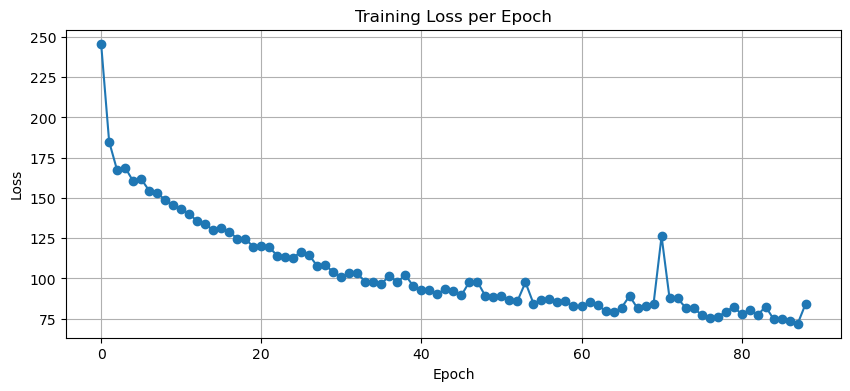

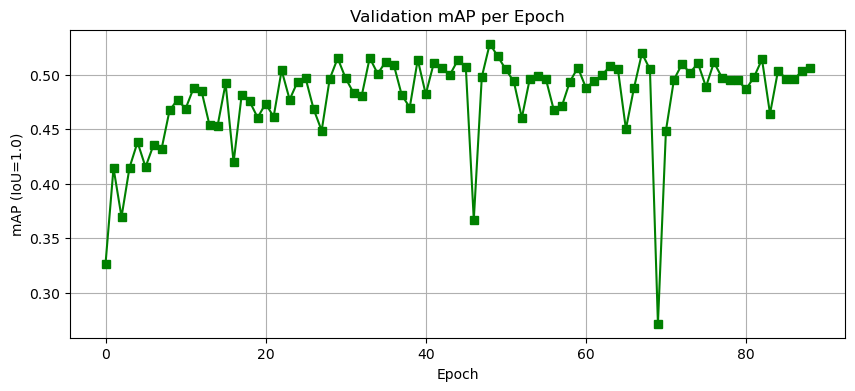

In [14]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 4))
plt.plot(epoch_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 4))
plt.plot(val_maps, marker='s', color='green')
plt.title("Validation mAP per Epoch")
plt.xlabel("Epoch")
plt.ylabel("mAP (IoU=1.0)")
plt.grid(True)
plt.show()

# Evaluating a Model on specific image

In [31]:

model.eval()


img_path = 'coco/test/100040.jpg'


img = Image.open(img_path).convert("RGB")


img_tensor = F.to_tensor(img).unsqueeze(0).to(device)


with torch.no_grad():
    output = model(img_tensor)[0] 

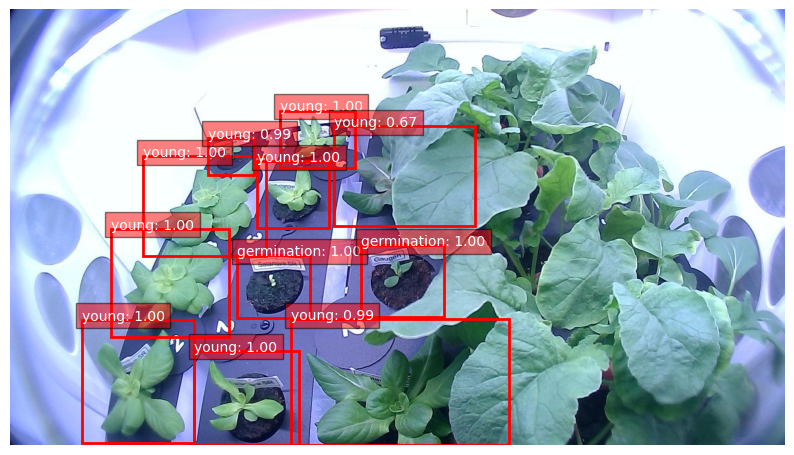

In [32]:

plt.figure(figsize=(10, 6))
plt.imshow(img) 
ax = plt.gca()   

# Loop through predicted boxes, labels, and scores
for box, label, score in zip(output['boxes'], output['labels'], output['scores']):
    if score > 0.5:  # The confidence threshold is set to 50%
       
        x1, y1, x2, y2 = box.cpu().numpy()

        
        ax.add_patch(plt.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            edgecolor='red', facecolor='none', linewidth=2
        ))

        
        ax.text(
            x1, y1,
            f"{CLASSES[label]}: {score:.2f}",
            color='white',
            bbox=dict(facecolor='red', alpha=0.5)
        )


plt.axis('off')
plt.show()


# Evaluating the model on the Train, Validation and Test Dataset
We will also produce the resultant metrics after evaluation. This code is inspired from the lab code.

In [20]:
# Evaluate the model on the training dataset
train_results = evaluate_map(model, train_loader)

# Print overall mAP/mAR results for the training set
print("📊 Train set mAP/mAR results:")
for k, v in train_results.items():
    # Convert torch tensors to NumPy arrays for clean printing
    if isinstance(v, torch.Tensor):
        print(f"{k}: {v.numpy()}")
    else:
        print(f"{k}: {v}")

📊 Train set mAP/mAR results:
map: 0.6065605687050292
map_50: 0.6065605687050292
map_75: 0.6065605687050292
map_per_class: [0.60413675 0.56740695 0.66968032 0.53495962 0.6566192 ]
mar_1: 0.9274624662913251
mar_10: 0.9274624662913251
mar_100: 0.9274624662913251
mar_100_per_class: [0.92070642 0.93965482 0.92979694 0.98183572 0.86531843]


In [21]:
# Print header for per-class AP / AR table
print("\nAP / AR per class\n" + "-"*73)
print(f"| {'ID':<3} | {'Class':<20} | {'AP':<18} | {'AR':<18} |")
print("-"*73)

# Loop through each class (excluding background)
for i, cls in enumerate(CLASSES[1:], 1):
    # Get AP and AR for the current class
    ap = train_results['map_per_class'][i-1].item()
    ar = train_results['mar_100_per_class'][i-1].item()

    # Print formatted row
    print(f"| {i:<3} | {cls:<20} | {ap:<18.3f} | {ar:<18.3f} |")

# Print average AP and AR across all classes
print("-"*73)
print(f"| {'Avg':<24} | {train_results['map'].item():<18.3f} | {train_results['mar_100'].item():<18.3f} |")
print("-"*73)


AP / AR per class
-------------------------------------------------------------------------
| ID  | Class                | AP                 | AR                 |
-------------------------------------------------------------------------
| 1   | Ready                | 0.604              | 0.921              |
| 2   | empty_pod            | 0.567              | 0.940              |
| 3   | germination          | 0.670              | 0.930              |
| 4   | pod                  | 0.535              | 0.982              |
| 5   | young                | 0.657              | 0.865              |
-------------------------------------------------------------------------
| Avg                      | 0.607              | 0.927              |
-------------------------------------------------------------------------


In [22]:
# Evaluate the model on the validation dataset
val_results = evaluate_map(model, val_loader)

# Print overall mAP/mAR results for the validation set
print("\n📊 Validation set mAP/mAR results:")
for k, v in val_results.items():
    # Convert tensors to NumPy arrays for cleaner output
    if isinstance(v, torch.Tensor):
        print(f"{k}: {v.numpy()}")
    else:
        print(f"{k}: {v}")



📊 Validation set mAP/mAR results:
map: 0.5061686263711783
map_50: 0.5061686263711783
map_75: 0.5061686263711783
map_per_class: [0.44027282 0.58192929 0.54149926 0.43002574 0.53711602]
mar_1: 0.7737384632867963
mar_10: 0.7737384632867963
mar_100: 0.7737384632867963
mar_100_per_class: [0.67310463 0.84766057 0.78023832 0.8417688  0.72592   ]


In [23]:
# Print header for per-class AP / AR table
print("\nAP / AR per class\n" + "-"*73)
print(f"| {'ID':<3} | {'Class':<20} | {'AP':<18} | {'AR':<18} |")
print("-"*73)

# Loop through each class (excluding background)
for i, cls in enumerate(CLASSES[1:], 1):
    # Get AP and AR for the current class
    ap = val_results['map_per_class'][i-1].item()
    ar = val_results['mar_100_per_class'][i-1].item()

    # Print formatted row
    print(f"| {i:<3} | {cls:<20} | {ap:<18.3f} | {ar:<18.3f} |")

# Print average AP and AR across all classes
print("-"*73)
print(f"| {'Avg':<24} | {val_results['map'].item():<18.3f} | {val_results['mar_100'].item():<18.3f} |")
print("-"*73)


AP / AR per class
-------------------------------------------------------------------------
| ID  | Class                | AP                 | AR                 |
-------------------------------------------------------------------------
| 1   | Ready                | 0.440              | 0.673              |
| 2   | empty_pod            | 0.582              | 0.848              |
| 3   | germination          | 0.541              | 0.780              |
| 4   | pod                  | 0.430              | 0.842              |
| 5   | young                | 0.537              | 0.726              |
-------------------------------------------------------------------------
| Avg                      | 0.506              | 0.774              |
-------------------------------------------------------------------------


In [24]:
# Evaluate the model on the test dataset
test_results = evaluate_map(model, test_loader)

# Print overall mAP/mAR results for the test set
print("\n📊 Test set mAP/mAR results:")
for k, v in test_results.items():
    # Convert torch tensors to NumPy arrays for cleaner display
    if isinstance(v, torch.Tensor):
        print(f"{k}: {v.numpy()}")
    else:
        print(f"{k}: {v}")



📊 Test set mAP/mAR results:
map: 0.4910559957352799
map_50: 0.4910559957352799
map_75: 0.4910559957352799
map_per_class: [0.45484148 0.49074714 0.583174   0.39856236 0.527955  ]
mar_1: 0.7789747063325662
mar_10: 0.7789747063325662
mar_100: 0.7789747063325662
mar_100_per_class: [0.76975472 0.78194417 0.83757826 0.78650423 0.71909215]


In [25]:
# Print table header for per-class AP and AR
print("\nAP / AR per class on test\n" + "-"*73)
print(f"| {'ID':<3} | {'Class':<20} | {'AP':<18} | {'AR':<18} |")
print("-"*73)

# Loop through each class (excluding background)
for i, cls in enumerate(CLASSES[1:], 1):
    # Get AP and AR for the current class
    ap = test_results['map_per_class'][i-1].item()
    ar = test_results['mar_100_per_class'][i-1].item()

    # Print table row for the class
    print(f"| {i:<3} | {cls:<20} | {ap:<18.3f} | {ar:<18.3f} |")

# Print average AP and AR across all classes
print("-"*73)
print(f"| {'Avg':<24} | {test_results['map'].item():<18.3f} | {test_results['mar_100'].item():<18.3f} |")
print("-"*73)



AP / AR per class on test
-------------------------------------------------------------------------
| ID  | Class                | AP                 | AR                 |
-------------------------------------------------------------------------
| 1   | Ready                | 0.455              | 0.770              |
| 2   | empty_pod            | 0.491              | 0.782              |
| 3   | germination          | 0.583              | 0.838              |
| 4   | pod                  | 0.399              | 0.787              |
| 5   | young                | 0.528              | 0.719              |
-------------------------------------------------------------------------
| Avg                      | 0.491              | 0.779              |
-------------------------------------------------------------------------


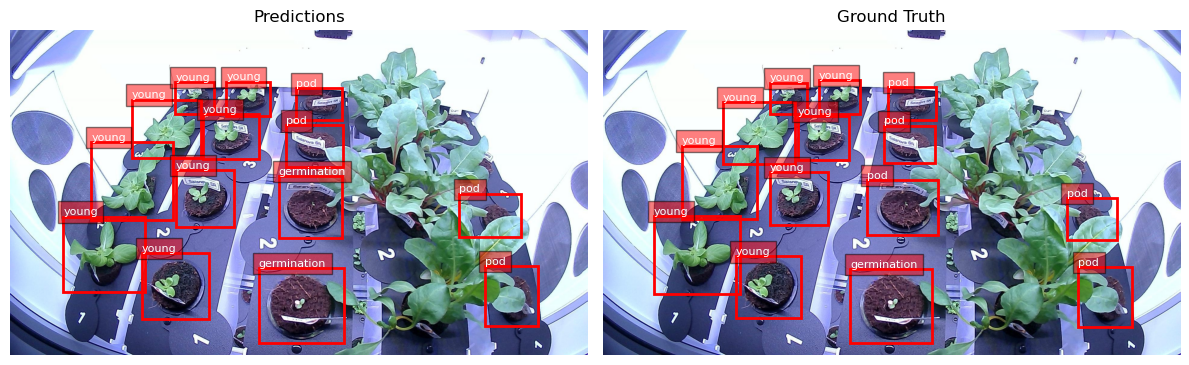

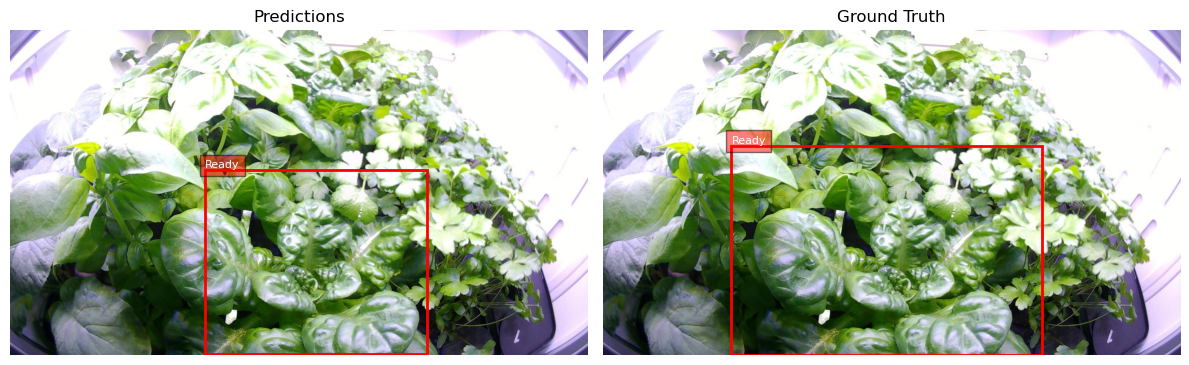

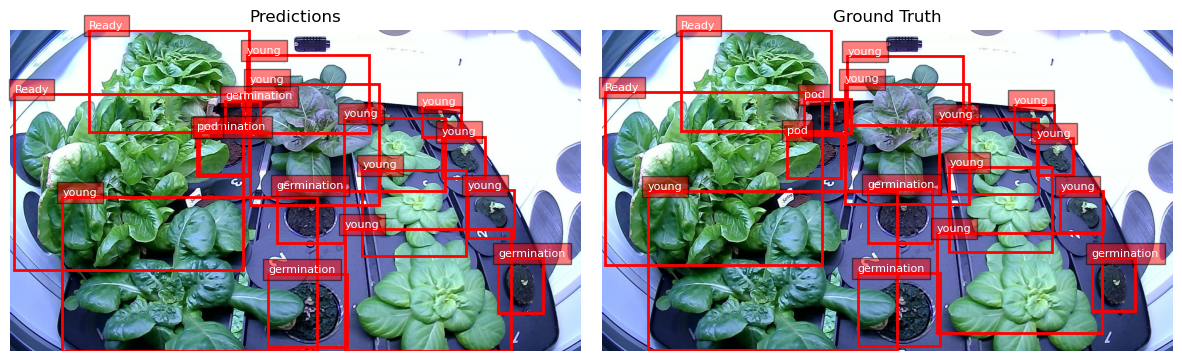

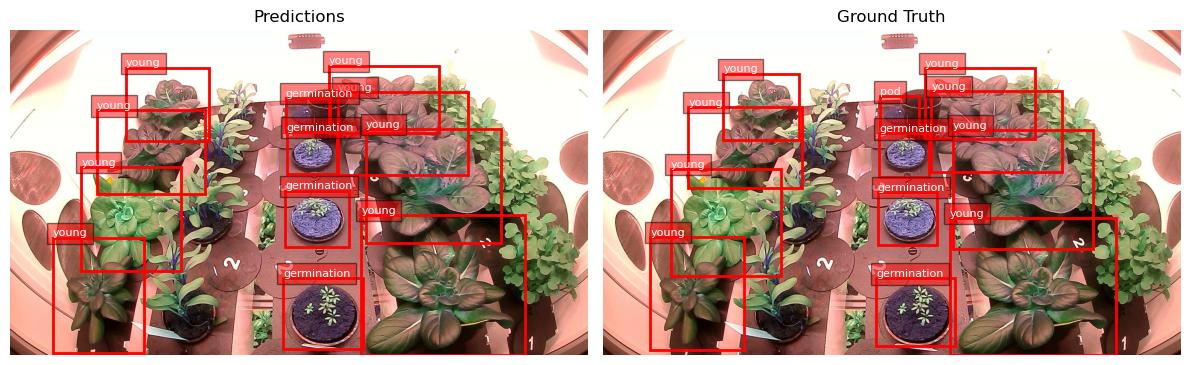

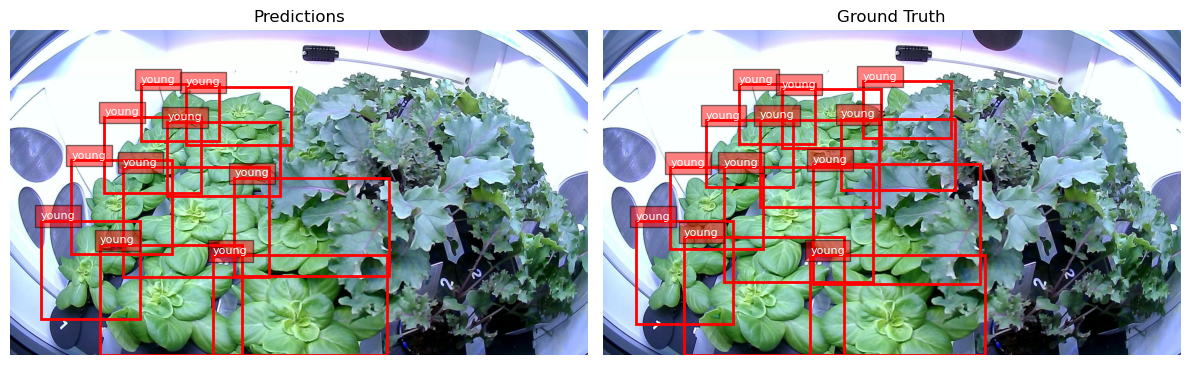

In [26]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import matplotlib.patches as patches


category_names = {
    1: "Ready",
    2: "empty_pod",
    3: "germination",
    4: "pod",
    5: "young"
}

# Helper function to plot boxes
def plot_boxes(ax, image, boxes, labels, title):
    ax.imshow(image.permute(1, 2, 0))  
    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box.tolist()
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        label_name = category_names.get(label.item(), str(label.item()))
        ax.text(x1, y1 - 5, label_name, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))
    ax.set_title(title)
    ax.axis('off')

# Model in eval mode
model.eval()

# Visualize N sample images
N = 5
count = 0

with torch.no_grad():
    for images, targets in test_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for i in range(len(images)):
            img = images[i].cpu()
            pred = outputs[i]
            target = targets[i]

            # Filter predictions with confidence threshold
            keep = pred['scores'] > 0.5
            pred_boxes = pred['boxes'][keep].cpu()
            pred_labels = pred['labels'][keep].cpu()

            gt_boxes = target['boxes'].cpu()
            gt_labels = target['labels'].cpu()

            # Create side-by-side plots
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            plot_boxes(axes[0], img, pred_boxes, pred_labels, "Predictions")
            plot_boxes(axes[1], img, gt_boxes, gt_labels, "Ground Truth")
            plt.tight_layout()
            plt.show()

            count += 1
            if count >= N:
                break
        if count >= N:
            break
